# DKTC Baseline 모델링 (TF-IDF + Logistic Regression)

## 1. 데이터 준비

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 데이터 로드
train_df = pd.read_csv('../../data/train.csv')
general_df = pd.read_csv('../../data/train_daily.csv')

# 데이터 합치기
df = pd.concat([train_df, general_df], ignore_index=True)

# 중복 제거
print(f'중복 제거 전 데이터 크기: {len(df)}')
df.drop_duplicates(subset=['conversation'], keep='first', inplace=True, ignore_index=True)
print(f'중복 제거 후 데이터 크기: {len(df)}')

# README에 지정된 클래스 인덱스 정보 매핑
class_mapping = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}
df['class'] = df['class'].map(class_mapping)

# 훈련/검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(
    df['conversation'], 
    df['class'], 
    test_size=0.2, 
    random_state=42,
    stratify=df['class']
)

print(f'Train data size: {len(X_train)}')
print(f'Validation data size: {len(X_val)}')

중복 제거 전 데이터 크기: 4850
중복 제거 후 데이터 크기: 4744
Train data size: 3795
Validation data size: 949


## 2. TF-IDF 벡터화 (with N-grams)

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from mecab_ko import Tagger

# Tokenizer 정의
mecab_tagger = Tagger()
def mecab_tokenizer(text):
    parsed = mecab_tagger.parse(text)
    return [line.split('\t')[0] for line in parsed.split('\n') if '\t' in line]

# TF-IDF 벡터화 (1,3-gram)
print("TF-IDF 벡터화 진행 중... (전체 학습 데이터 사용)")
tfidf_vectorizer = TfidfVectorizer(tokenizer=mecab_tokenizer, ngram_range=(1, 3), min_df=3, max_df=0.9)

# 훈련 데이터에 대해 TF-IDF 학습 및 변환
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# 검증 데이터에 대해 TF-IDF 변환
X_val_tfidf = tfidf_vectorizer.transform(X_val)

print(f'Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}')
print(f'Train TF-IDF matrix shape: {X_train_tfidf.shape}')

TF-IDF 벡터화 진행 중... (전체 학습 데이터 사용)


/Users/bychoi/miniforge3/envs/my-pytorch/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Vocabulary size: 41356
Train TF-IDF matrix shape: (3795, 41356)


## 3. 로지스틱 회귀 모델 학습 및 평가

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

# 최적의 C값(C=5)으로 모델 최종 학습 및 평가
lr_model = LogisticRegression(random_state=42, max_iter=1000, C=5)
lr_model.fit(X_train_tfidf, y_train)

# 예측
y_pred = lr_model.predict(X_val_tfidf)

# 평가
weighted_f1 = f1_score(y_val, y_pred, average='weighted')
print(f'Weighted F1 Score: {weighted_f1:.4f}')

# 클래스별 상세 리포트
# target_names를 지정하기 위해 class_mapping의 역순 딕셔너리를 만듭니다.
class_names = [name for name, num in sorted(class_mapping.items(), key=lambda item: item[1])]
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=class_names))

Weighted F1 Score: 0.9041
Classification Report:
              precision    recall  f1-score   support

       협박 대화       0.87      0.86      0.86       178
       갈취 대화       0.87      0.85      0.86       195
 직장 내 괴롭힘 대화       0.92      0.93      0.93       194
   기타 괴롭힘 대화       0.86      0.89      0.88       202
       일반 대화       1.00      0.99      1.00       180

    accuracy                           0.90       949
   macro avg       0.91      0.90      0.91       949
weighted avg       0.90      0.90      0.90       949



## 4. 오분류 분석

In [4]:
# 예측이 틀린 데이터들을 확인합니다.

# 1. 결과 합치기
error_df = pd.DataFrame({
    'conversation': X_val,
    'true_label': y_val,
    'predicted_label': y_pred
})

# 2. 라벨 디코딩 (숫자 -> 클래스 이름)
# 클래스 인덱스를 클래스 이름으로 매핑하기 위한 역매핑 딕셔너리 생성
reverse_class_mapping = {v: k for k, v in class_mapping.items()}

error_df['true_label_name'] = error_df['true_label'].map(reverse_class_mapping)
error_df['predicted_label_name'] = error_df['predicted_label'].map(reverse_class_mapping)

# 3. 틀린 예측만 필터링
misclassified = error_df[error_df['true_label'] != error_df['predicted_label']].copy()

# 4. 결과 확인
print(f'총 {len(misclassified)}개의 오분류 데이터 발견')
print('\n--- 오분류 데이터 샘플 ---')

# 대화 내용이 잘리지 않도록 출력 옵션 설정
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 300) 

display(misclassified[['conversation', 'true_label_name', 'predicted_label_name']])

총 91개의 오분류 데이터 발견

--- 오분류 데이터 샘플 ---


,conversation,true_label_name,predicted_label_name
177,여보 이제 슬슬 당신도 일 해야하지 않을까?\n응 ? 왜 ?\n나 혼자 버는 돈으로 힘드니까.\n싫어 당신이 돈 더 벌어오면 되는거아니야 ? 결혼 할때 약속했잖아 난 육아만한다고\n아.\n이것봐 결혼하면 다 변한다니까? 당신이 밖에서 일하는것보다 육아가 더 힘들어\n그건.좀.\n나는 일 할 생각없고 당신이 투잡을 하던 뭘 하던 알아서해\n하.\n밖에서 일하는게 뭐 얼마나 힘들다고 이래? 당신이 일머리가 나쁜게 아닐까? 다른 남자들도 다 하는데 당신은 왜 못해?,기타 괴롭힘 대화,갈취 대화
3331,야 1반 찐따\n왜 불러.\n니네 누나는 너랑 다르게 찐따는 아니더라 반대던데?\n어.어.\n유전자 몰빵이 그런건가보지?\n누나 이야기는 왜하는거야\n아니 니네 누나가 내스탈이라서 연락처좀 건내줘\n안돼.우리누나는 괴롭히지마\n누가 괴롭힌데 병신아 장난아니니까연락처 건네주라고\n시.싫어\n그래? 그럼 니입에서 좋다는 소리가 나올때까지 디지게 맞든가\n아니면 매형소리 나올때까지 쳐맞을까?,협박 대화,기타 괴롭힘 대화
2820,야 너 이리와봐 경례 똑바로 안하냐?\n네 죄송합니다. \n뭐가 죄송한데\n경례 똑바로 안해서 죄송합니다. \n미쳤네 말대답하냐?\n죄송합니다. \n너 따위 죄송 필요없고 대가리 박아 \n네 알겠습니다. \n자 따라한다 실시! \n나는 구제불능이다.\n나는 구제불능이다.,기타 괴롭힘 대화,직장 내 괴롭힘 대화
1970,혹시 민지님 맞나요? 아니 다른게 아니고 우리 회사 워크숍 있잖아 아직 도착전이야?\n지금 다 도착해있는데 무슨소리야 단체 메시지 못 봤어? 장소 변경 됐잖아.\n아 진짜? 잠시만 확인해볼게 음. 나는 그런 메시지 받은 적 없는데. 확인 좀 해줄래?\n저기 과장님 씨가 바뀐 워크숍 장소 못 들었다는데 무슨 소릴까요?\n아 깜박하고 못 보내줬나 보네 알아서 차타고 오던 해 근데 늦지 않게 와 늦으면 나중에 인사평가 문제 되는 거 알지?\n여기서 가는데 최소 2시간 이상은 걸려서 늦을거 같은데요. 문자가 안 와서 여기로 온건데 ...,직장 내 괴롭힘 대화,기타 괴롭힘 대화
3310,중구가 시키드나? 경찰들 논간에 놀아나는 거여\n어이 정청 이 짱개새꺄 우리가 개 호구로 보이냐?\n이런 모지리들\n뭐 이새꺄!!\n드루와 드루와\n이런 미친!!\n야 다 드루와 드루와 \n죽어 이 짱개 새꺄!!\n너네는 오늘 내한테 다 죽는다!!\n억!!! 중구 형님.,협박 대화,기타 괴롭힘 대화
3394,당신 손녀를 지금 데리고있다.\n네??? 제 손녀를 데리고 있다고요?\n그래. 내가 당신 손녀를 데리고 있어. \n무슨 소리세요 제 손녀를 데리고있다니!\n당신 손녀를 구하고 싶으면 지금 당장 계좌에 1억을 입금해 \n1억이라니요 그런 큰 돈 없어요\n그럼 손녀를 살리고 싶지 않은건가? \n아니요 하지만 그렇게 큰돈을 마련할수없어요 제 손녀를 살려주세요\n당장 입금하지 않으면 손녀는 죽일 거다\n안돼요 무슨말이에요 제 손녀를 건들지 마세요,협박 대화,갈취 대화
3346,야! 너 어제 월급 아니였어?\n네.? 아 엄마. 맞아요.\n아니 그럼 월급을 받았으면 바로 보내야지 뭐하는거야!?\n아.제가 이번에 학원비랑.생활용품이 필요해서.\n그건 니가 알아서 할 문제고 너 이제 집안 신경안쓰기로 한거야?\n아.아니에요. 근데 저도 제가 벌어서 제가 필요한 거 산거라.\n어머어머 얘 봐. 너 내가 무슨 계모인 것 처럼 얘기한다? 지금 집안에 돈 벌어 올 수 있는 사람이 너 밖에 없는 거 알면서 어?\n죄송합니다.\n얼마 남았는데? 빨리 안붙여!?\n저도 제가.쓸 비용은 좀 . 빼놓고.\n잔말 말고 당...,갈취 대화,직장 내 괴롭힘 대화
3313,당신의 아이를 데리고 있다.\n 네? 뭐라고요?\n 니 자식을 살리고 싶으면 지금 바로 1억을 준비해라.\n 엄마!! 살려주세요!!\n 여보세요. 누구세요?\n 지금 당장 돈을 준비해서 하천 옆 굴다리로 와라.\n 이보세요? 여보세요?\n 엄마!!\n 지금부터 세 시간을 주겠다. 만약 신고하거나 허튼짓을 하면 니 자식을 영영 못 볼 줄 알아라.\n 네!! 알겠습니다!! 일단 우리 애. 우리 애 좀 바꿔주세요. 애는 괜찮은거죠?\n 돈 들고 혼자 나와라.\n 여보세요? 여보세요!!!,갈취 대화,협박 대화
1353,성격이 왜 그래?\n네?\n말투도 이상하고\n어떻게 하라는 말씀인지.\n이해력도 떨어지고\n네?\n도대체가 안맞아\n성격이 마음에 안드신다는 얘기면 고쳐보겠습니다\n다 마음에 안든다고\n그렇다면 저도 어떡해야 할지,기타 괴롭힘 대화,직장 내 괴롭힘 대화
2010,아! 부딪혔으면 사과를 해야지!\n미.미안\n생각해보니까 열 받네 아까 피할 수 있는데 왜 부딪힌거냐? 일부로 그런 거냐?\n미안하다고 했잖아\n그니까 미안하다고 하면 다냐고!\n그럼 내가 어떻게 해줄까\n점심시간까지 우리 반으로 와. 그 다음에 알려줄게.\n그냥 여기서 해결하면 안 될까\n애들 다 보는 앞에서 맞고 싶은 거냐?\n알았어점심시간에 갈게.,기타 괴롭힘 대화,협박 대화


## 5. 모델 저장

In [5]:
import joblib

# 모델과 벡터라이저를 저장합니다.
joblib.dump(lr_model, '../saved_models/lr_model_c5.pkl')
joblib.dump(tfidf_vectorizer, '../saved_models/tfidf_vectorizer.pkl')

print("모델과 벡터라이저가 '02. 모델링/saved_models/' 폴더에 저장되었습니다.")

모델과 벡터라이저가 '02. 모델링/saved_models/' 폴더에 저장되었습니다.


## 6. 오분류 분석

총 오분류 데이터 수: 91


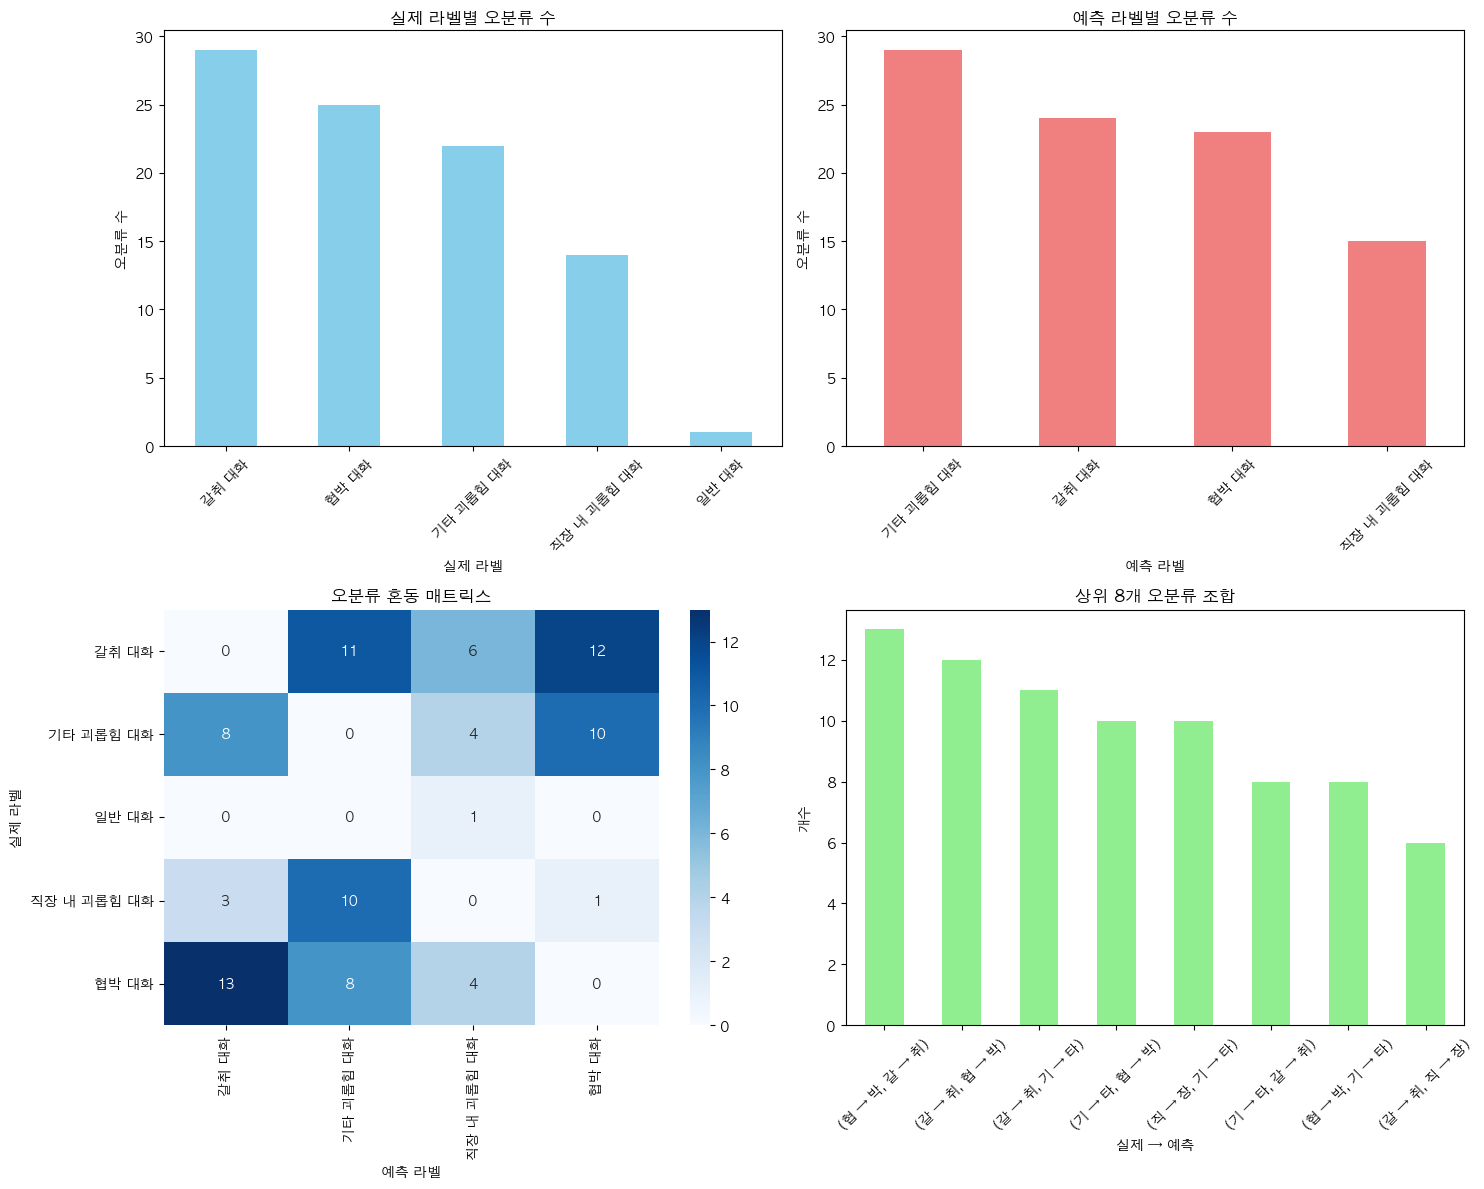

In [6]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 한글 폰트 설정 (macOS)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 필요한 데이터가 준비되어 있는지 확인
if 'misclassified' not in globals():
    # 앞선 셀에서 생성한 error_df / misclassified가 없는 경우 재계산
    error_df = pd.DataFrame({
        'conversation': X_val,
        'true_label': y_val,
        'predicted_label': y_pred
    })
    reverse_class_mapping = {v: k for k, v in class_mapping.items()}
    error_df['true_label_name'] = error_df['true_label'].map(reverse_class_mapping)
    error_df['predicted_label_name'] = error_df['predicted_label'].map(reverse_class_mapping)
    misclassified = error_df[error_df['true_label'] != error_df['predicted_label']].copy()

print(f"총 오분류 데이터 수: {len(misclassified)}")

# 실제/예측 라벨 분포
true_label_counts = misclassified['true_label_name'].value_counts()
predicted_label_counts = misclassified['predicted_label_name'].value_counts()

# 혼동 매트릭스 (오분류에 대해서만)
confusion_df = pd.crosstab(
    misclassified['true_label_name'], 
    misclassified['predicted_label_name']
)

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1) 실제 라벨별 오분류 수
true_label_counts.plot(kind='bar', color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('실제 라벨별 오분류 수')
axes[0, 0].set_xlabel('실제 라벨')
axes[0, 0].set_ylabel('오분류 수')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2) 예측 라벨별 오분류 수
predicted_label_counts.plot(kind='bar', color='lightcoral', ax=axes[0, 1])
axes[0, 1].set_title('예측 라벨별 오분류 수')
axes[0, 1].set_xlabel('예측 라벨')
axes[0, 1].set_ylabel('오분류 수')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3) 혼동 매트릭스 히트맵
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('오분류 혼동 매트릭스')
axes[1, 0].set_xlabel('예측 라벨')
axes[1, 0].set_ylabel('실제 라벨')

# 4) 상위 혼동 조합 Top-N 바차트
combo_series = (
    misclassified.groupby(['true_label_name', 'predicted_label_name'])
    .size()
    .sort_values(ascending=False)
)

# 상위 8개만 표시
top_n = combo_series.head(8)
(top_n
 .rename(index=lambda x: f"{x[0]} → {x[1]}")
 .plot(kind='bar', color='lightgreen', ax=axes[1, 1]))
axes[1, 1].set_title('상위 8개 오분류 조합')
axes[1, 1].set_xlabel('실제 → 예측')
axes[1, 1].set_ylabel('개수')
axes[1, 1].tick_params(axis='x', rotation=45)

fig.tight_layout()
plt.show()
